# movie_tp

## Visualize BOLD time series

In [2]:
import sys, os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [3]:
csv_path = "./Movie_ROI/movie_tp/sub-NDARAG115LZP_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

def load_roi_cube(
    folder: str,
    pattern: str = "sub-*_ROI114.csv",
    n_roi: int = roi[0].shape,
    t_len: int = roi[1].shape,
    dtype=np.float32,
):
    folder = Path(folder)
    files = sorted(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matched: {folder / pattern}")

    arrays = []
    subject_ids = []

    for fp in files:
        df = pd.read_csv(fp)
        arr = df.to_numpy(dtype=dtype)
        arr = arr.T           
        arr = np.nan_to_num(arr)
        arrays.append(arr)

        m = re.search(r"sub-([A-Za-z0-9]+)", fp.name)
        subject_ids.append(m.group(1) if m else fp.stem)

    roi_all = np.stack(arrays, axis=0)  # (num_subjects, 114, 239)
    return roi_all, subject_ids

root_dir = "./Movie_ROI/movie_tp"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 239)
roi_all shape: (87, 114, 239)
num_subjects: 87
first 3 subjects: ['NDARAG115LZP', 'NDARAU967RWU', 'NDARBH133TK6']


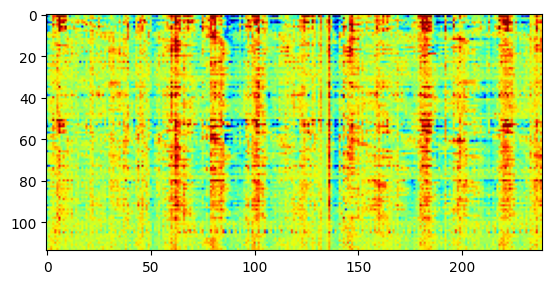

In [14]:
plt.imshow(roi_all[3], cmap="jet", vmin=-3, vmax=2)
# plt.colorbar()

Total data size: (87, 114, 239)
(114,)
Stable ROI IDs: [107 101 102 108 109]
Dynamic ROI IDs: [71 40 81 90 17]


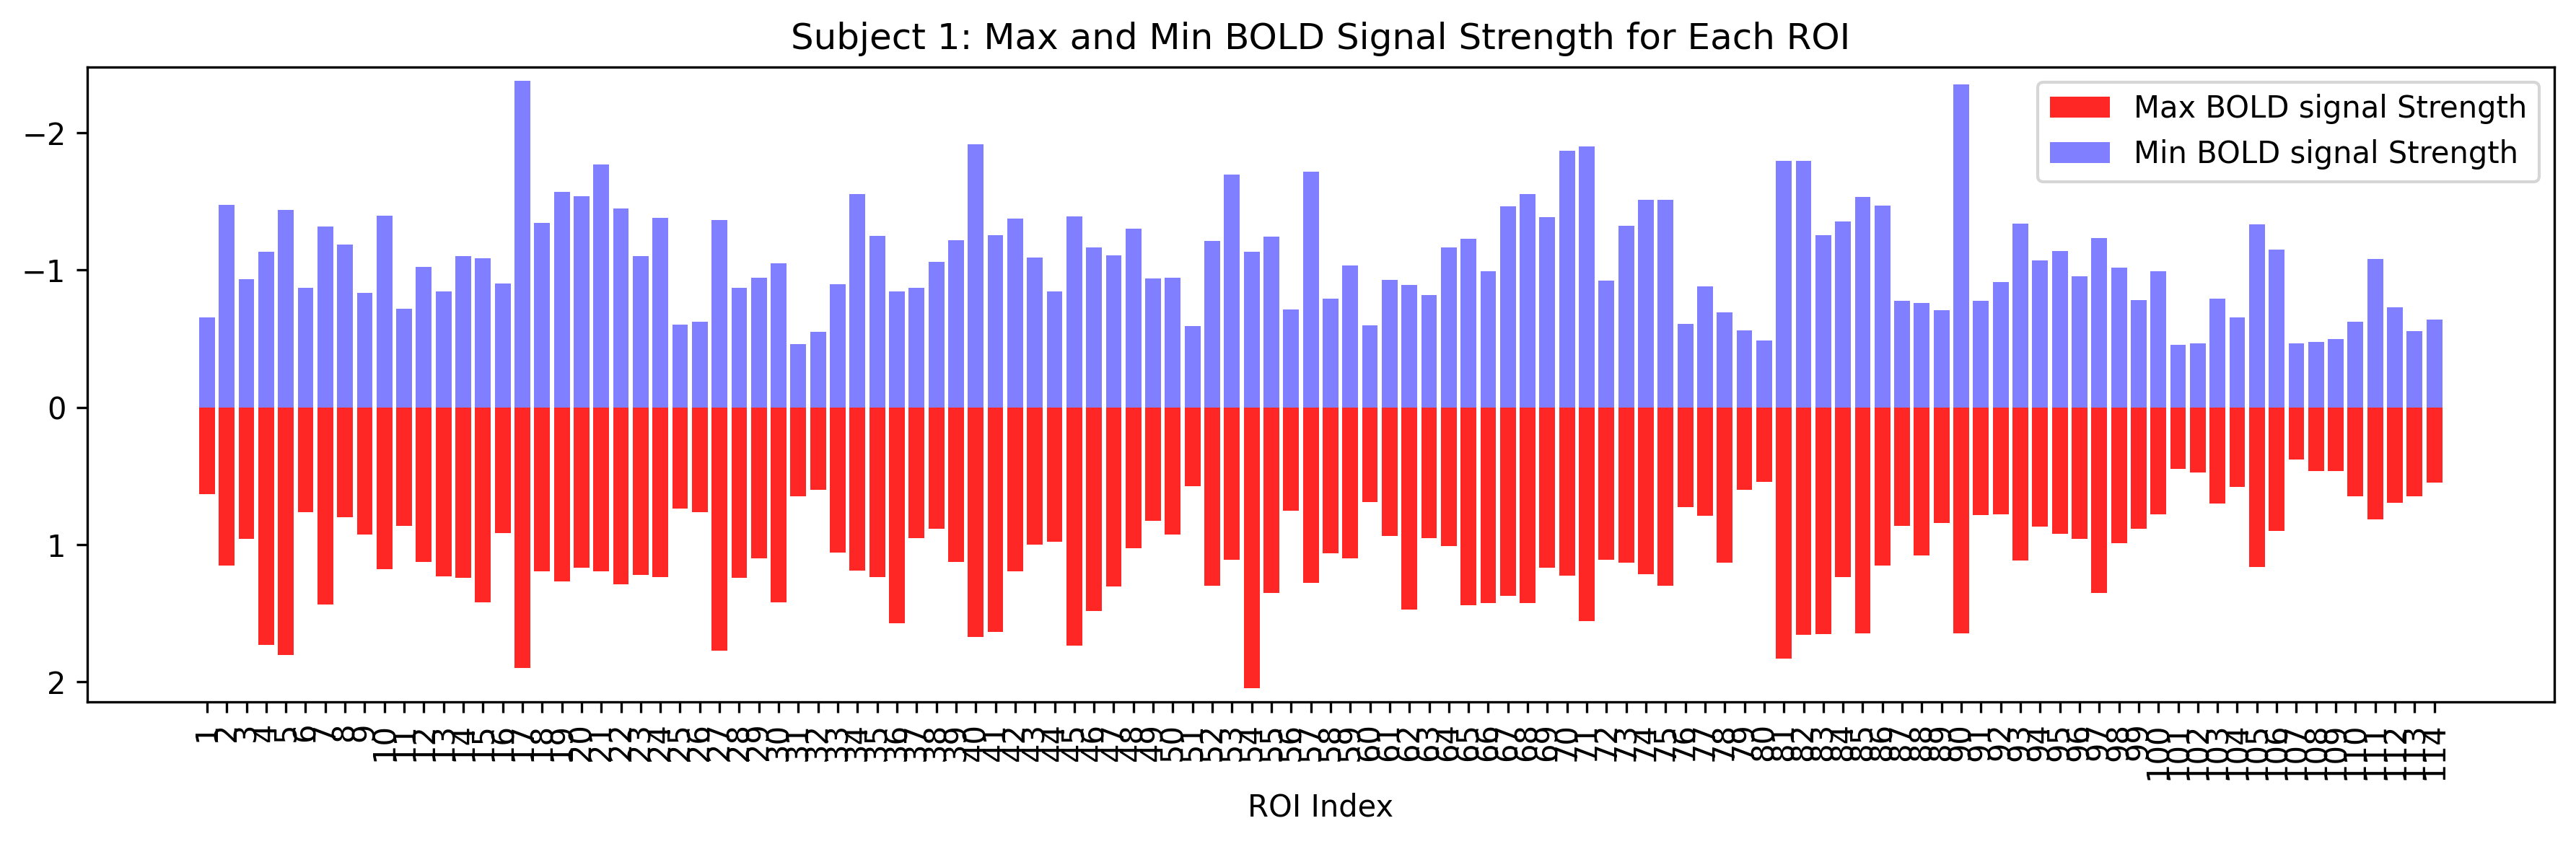

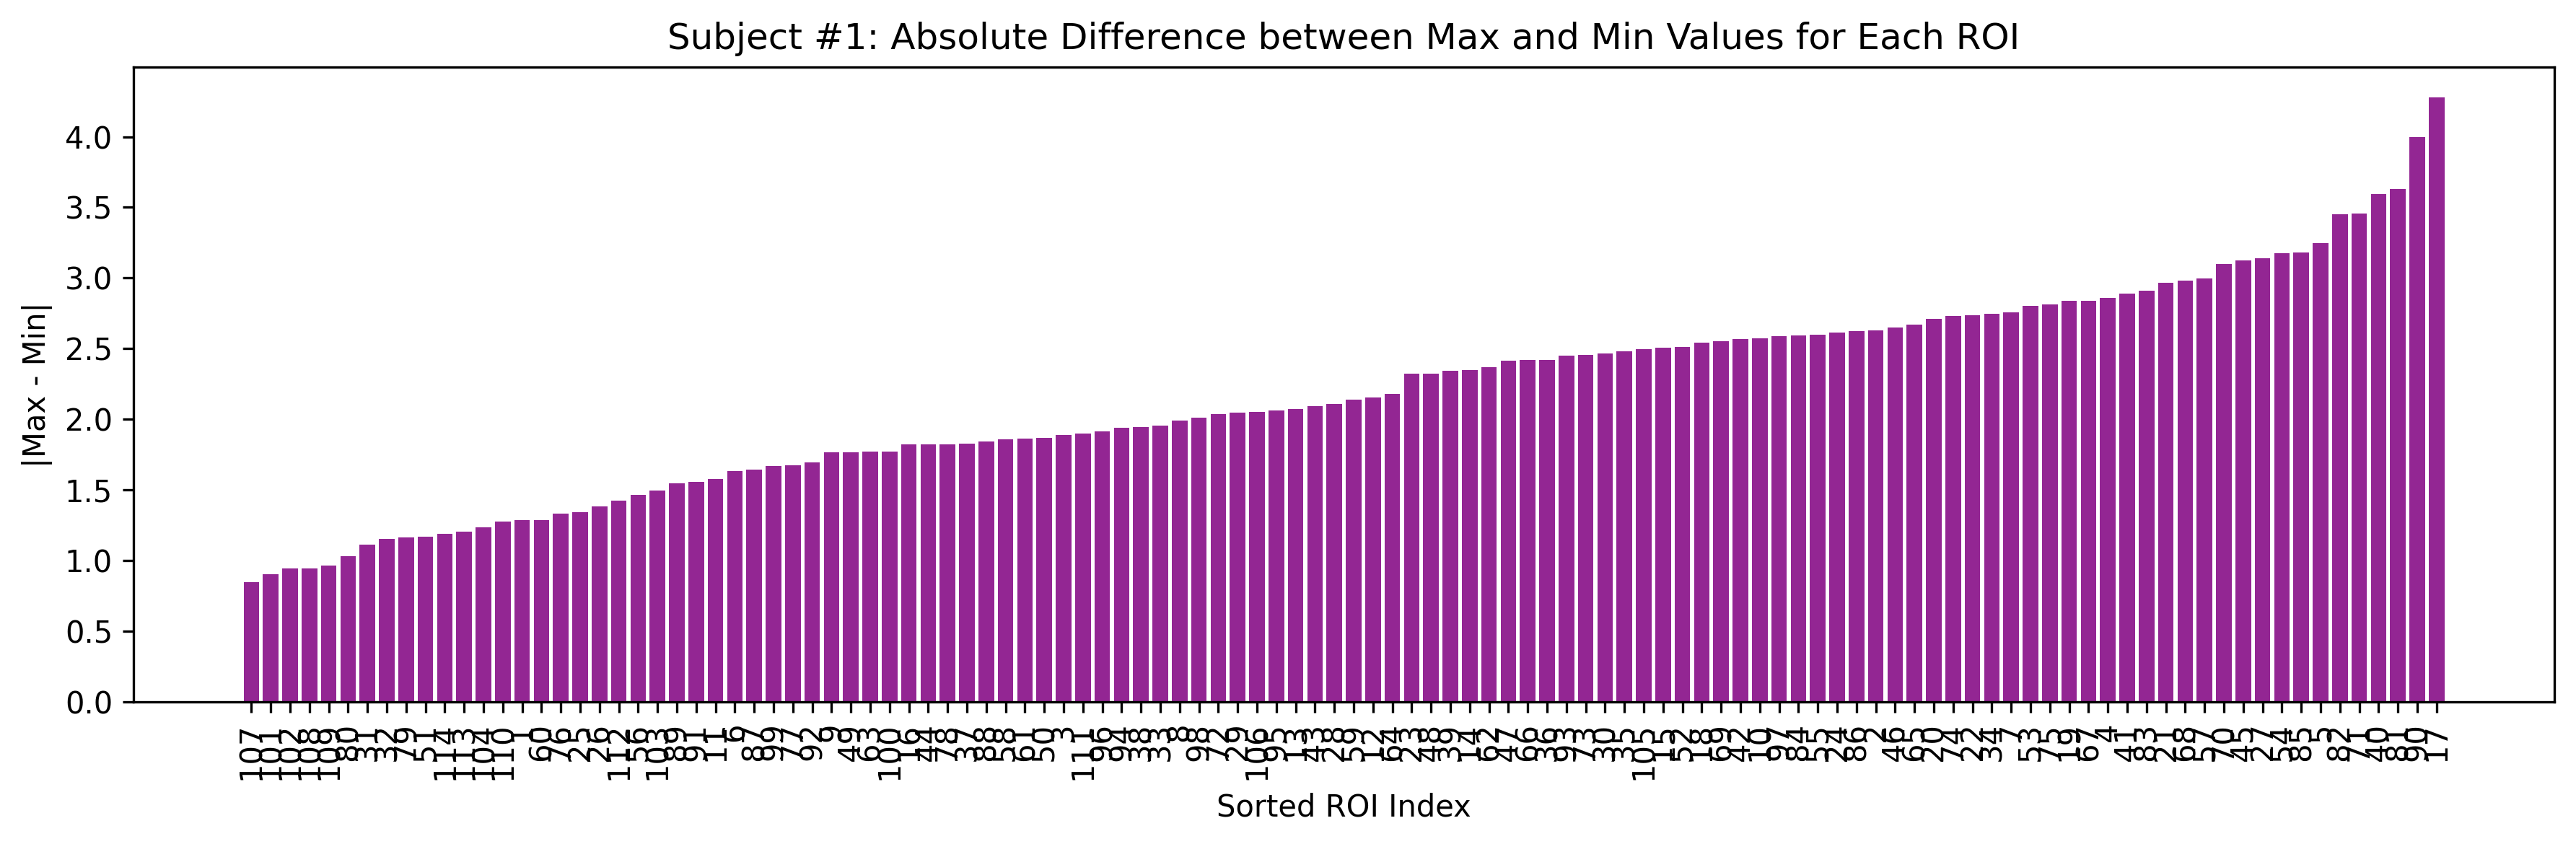

In [25]:
print('Total data size:', roi_all.shape)
plt.figure(figsize=[12, 4], dpi=300)
max_vals =np.array([roi_all[0][i].max() for i in range(114)])
min_vals =np.array([roi_all[0][i].min() for i in range(114)])
plt.bar(np.arange(114), max_vals, color='red', alpha=0.85)
plt.bar(np.arange(114), min_vals, color='blue', alpha=0.5)
plt.xticks(np.arange(114), np.arange(1, 115), rotation=90)
plt.xlabel('ROI Index')
plt.legend(['Max BOLD signal Strength', 'Min BOLD signal Strength'])
plt.ylim([max_vals.max()+.1, min_vals.min()-.1])
plt.title(f'Subject 1: Max and Min BOLD Signal Strength for Each ROI')
plt.tight_layout()
plt.savefig(f"sub_1_1", dpi=300)

# Calculate the absolute difference between max and min values for each ROI's BOLD signal
abs_diff = np.abs(np.array(max_vals) - np.array(min_vals))
print(abs_diff.shape)
# Sort the absolute differences and get the sorted indices
sorted_indices = np.argsort(abs_diff)

# Plot the sorted absolute differences
plt.figure(figsize=[12, 4], dpi=300)
plt.bar(np.arange(len(abs_diff)), abs_diff[sorted_indices], color='purple', alpha=0.85)
plt.xticks(np.arange(len(abs_diff)), sorted_indices + 1, rotation=90)
plt.xlabel('Sorted ROI Index')
plt.ylabel('|Max - Min|')
plt.title(f'Subject #1: Absolute Difference between Max and Min Values for Each ROI')
plt.tight_layout()
plt.savefig(f"sub_1_2", dpi=300)


print('Stable ROI IDs:', sorted_indices[:5]+1)
print('Dynamic ROI IDs:', sorted_indices[-5:]+1)

### ROI-level BOLD signals across 6 different subjects


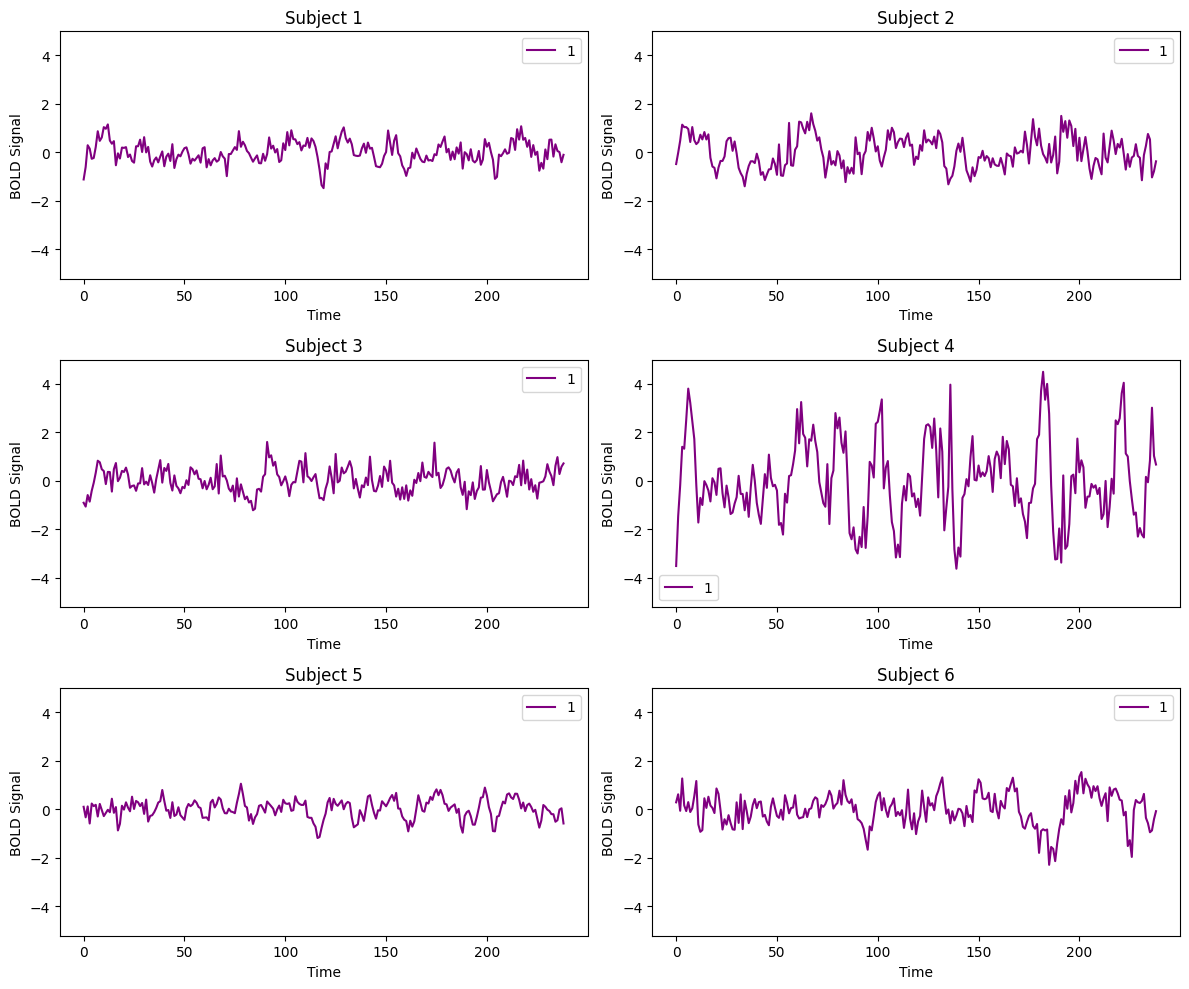

In [11]:
global_min = np.min([d.min() for d in roi_all[:6]])
global_max = np.max([d.max() for d in roi_all[:6]])

plt.figure(figsize=[12,10],dpi = 100)
r_id = 1 # roi index    

for sub_id in range(6): #  6 subjects
    reshaped_data = roi_all[sub_id].T    # (239,114)
    plt.subplot(3,2,sub_id+1)
    plt.plot(reshaped_data[:,r_id], 'purple')
    plt.ylim(global_min-.5, global_max+.5) # normalize y-range
    plt.xlabel('Time')
    plt.ylabel('BOLD Signal')
    plt.title(f'Subject {sub_id+1}')
    plt.legend([f'{r_id}'])
plt.tight_layout()
plt.savefig(f"roi_{r_id}", dpi=300)

### Visualize Subject-level BOLD signals

(87, 114, 239)


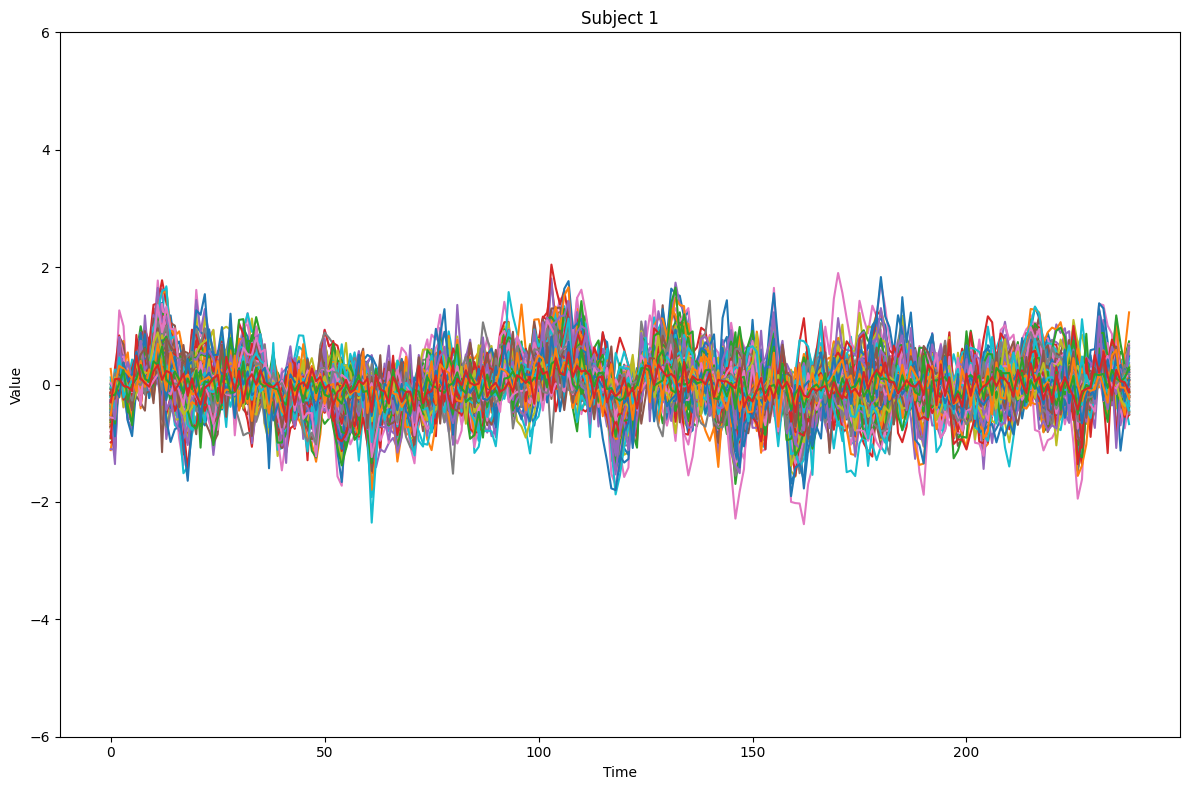

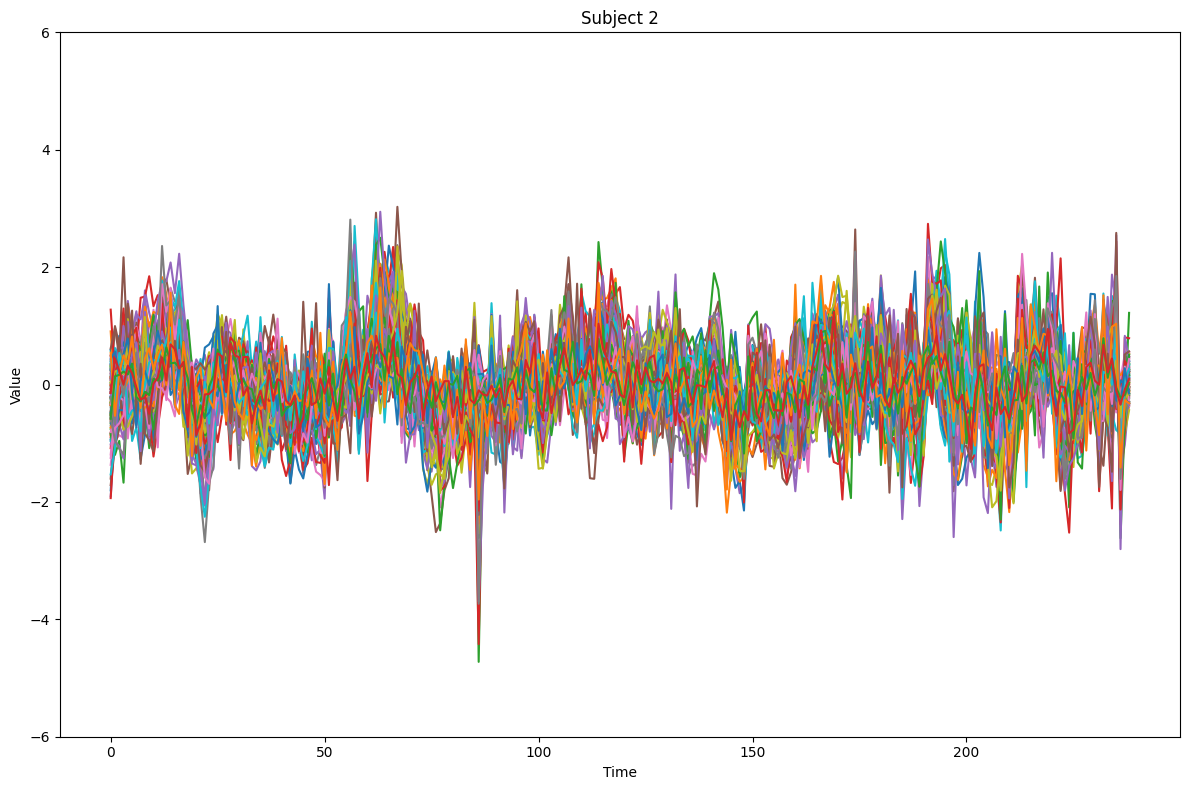

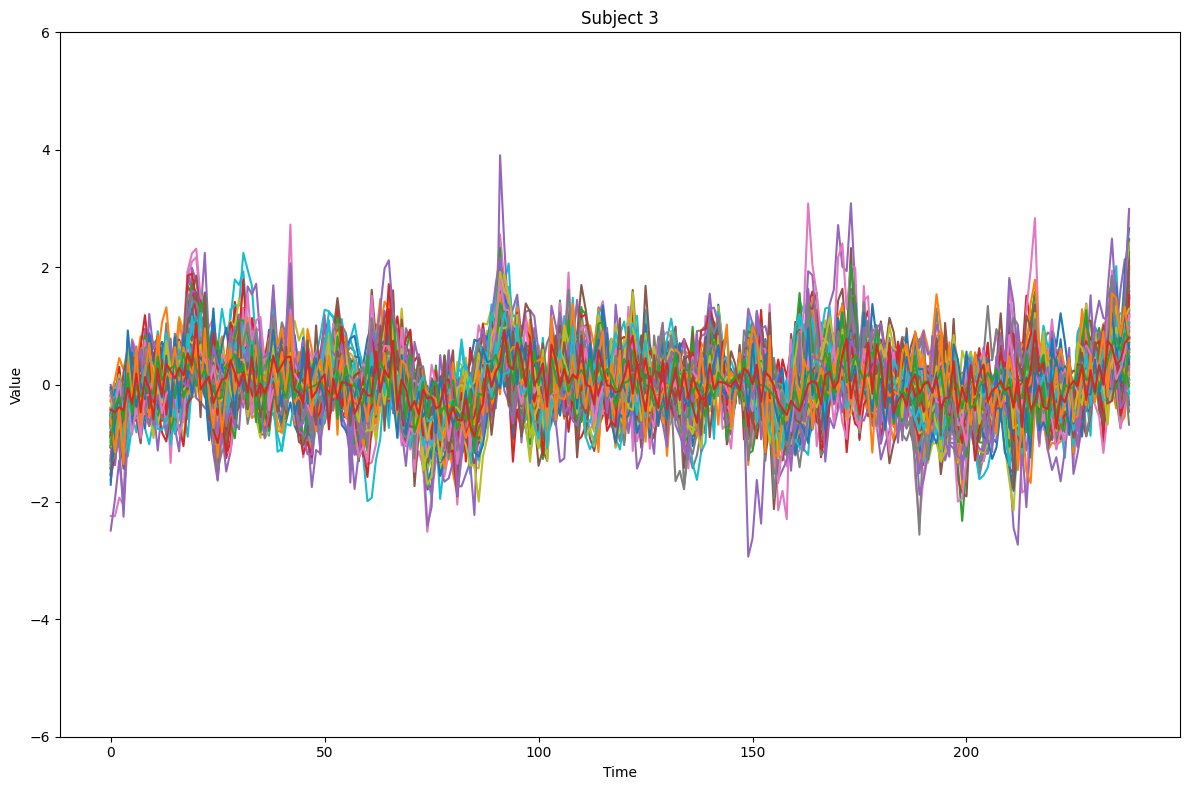

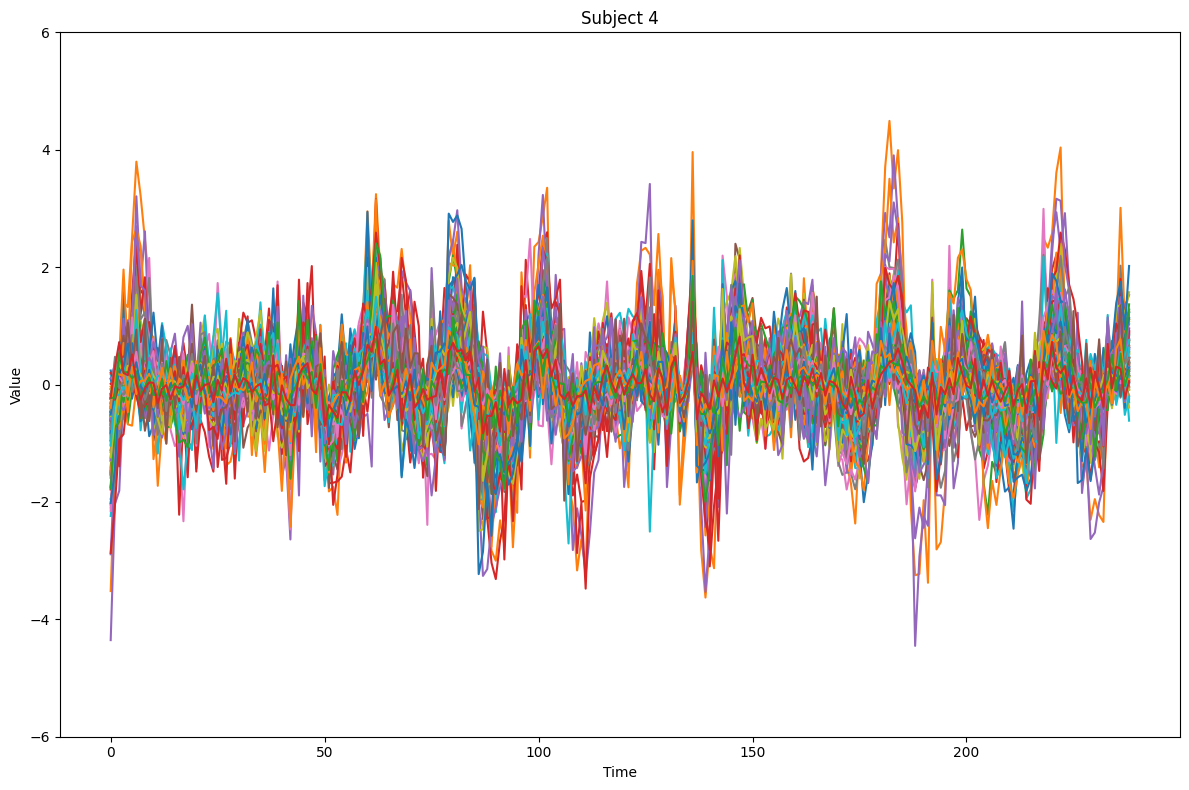

In [20]:
def plot_subject_fMRI_data(sub_id, ts_data):
    plt.figure(figsize=(12, 8))
    for i in range(ts_data[sub_id].shape[0]):
        sns.lineplot(data=ts_data[sub_id][i])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.ylim([-6, 6])
    plt.title(f'Subject {sub_id+1}')
        
    plt.tight_layout()
    plt.savefig(f"Subject_{sub_id+1}", dpi=300)

# roi_all: [87,114,239]
print(roi_all.shape)
plot_subject_fMRI_data(0, roi_all)
plot_subject_fMRI_data(1, roi_all)
plot_subject_fMRI_data(2, roi_all)
plot_subject_fMRI_data(3, roi_all)

## Visualize functional connectivity matrices for each subject

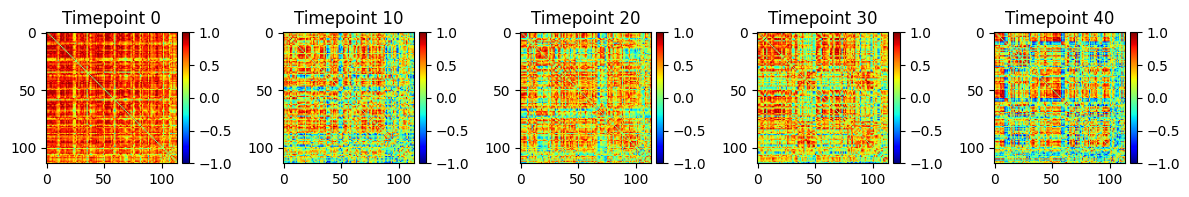

In [32]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compute_temporal_graphs(ts_data, subject_idx=0, window_size=20, step_size=5):

    subject_data = ts_data[subject_idx]  # Shape: [regions, timepoints]
    total_timepoints = subject_data.shape[1]

    # Normalize time series to avoid zero correlation issues
    subject_data = (subject_data - np.mean(subject_data, axis=1, keepdims=True)) / np.std(subject_data, axis=1, keepdims=True)

    # Compute the correct number of graphs
    num_graphs = (total_timepoints - window_size) // step_size + 1
    FC_mats = np.zeros((subject_data.shape[0], subject_data.shape[0], num_graphs))

    graphs = []
    graph_idx = 0
    for start in range(0, total_timepoints - window_size + 1, step_size):
        window = subject_data[:, start:start + window_size]  # Shape: [regions, window_size]

        # Compute functional connectivity (Pearson correlation) correctly
        corr_matrix = np.corrcoef(window, rowvar=True)  # Correlation across regions
        np.fill_diagonal(corr_matrix, 0)  # Remove self-connections

        FC_mats[:, :, graph_idx] = corr_matrix  # Store at correct index

        # Create a graph
        G = nx.from_numpy_array(corr_matrix)
        graphs.append(G)

        graph_idx += 1

    return graphs, FC_mats

def visualize_fc_matrices(FC_mats, SS):
    """Visualize functional connectivity matrices for selected timepoints with adjusted color bar length."""
    plt.figure(figsize=(12, 6))
    num_plots = len(SS)
    for s, timepoint in enumerate(SS):
        ax = plt.subplot(1, num_plots, s + 1)
        im = ax.imshow(FC_mats[:, :, timepoint], cmap='jet', vmin=-1, vmax=1)
        ax.set_title(f'Timepoint {timepoint}')

        # Adjust color bar to match graph size
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.savefig(f"sub_1_fc", dpi=300)
    plt.show()

temporal_graphs, FC_mats = compute_temporal_graphs(roi_all, subject_idx=0, window_size=10, step_size=5)
visualize_fc_matrices(FC_mats,[0,10,20,30,40])

### TEA plot and average novelty

In [33]:
import numpy as np
import networkx as nx

def compute_binary_temporal_graphs(FC_mats, threshold=0.1):

    binary_matrices = []

    for i in range(FC_mats.shape[2]):  # Iterate over time points
        correlation_matrix = FC_mats[:, :, i]

        # Convert to binary adjacency matrix using the threshold
        # binary_matrix = (np.abs(correlation_matrix) > threshold).astype(int) # 36830, 34270, 37662
        binary_matrix = (correlation_matrix > threshold).astype(int) # 35730, 33668, 36178

        # Store binary matrix
        binary_matrices.append(binary_matrix)

    return np.array(binary_matrices)

binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)
print(len(binary_temporal_graphs), binary_temporal_graphs.shape)

46 (46, 114, 114)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import make_interp_spline

def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        novelty_index = len(new_edges) / total_edges if total_edges > 0 else 0
        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    average_novelty_index = np.mean(novelty_indices) if novelty_indices else 0

    return novelty_indices, average_novelty_index

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        novelty_indices, average_novelty_index = compute_novelty_index(dynfc_matrices)

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]

        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold} (Avg. Novelty: {average_novelty_index:.2f})', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 10))
        
        # Smoothing the novelty index curve with a thinner red color
        if len(x_vals) > 1:
            x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
            novelty_smooth = make_interp_spline(x_vals, novelty_indices, k=3)(x_smooth)
            ax3.plot(x_smooth, novelty_smooth, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        else:
            ax3.plot(x_vals, novelty_indices, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        
        ax3.set_ylabel('Novelty Index', fontsize=12, color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        ax3.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig("TEA1.png", dpi=300, bbox_inches='tight')
    plt.show()


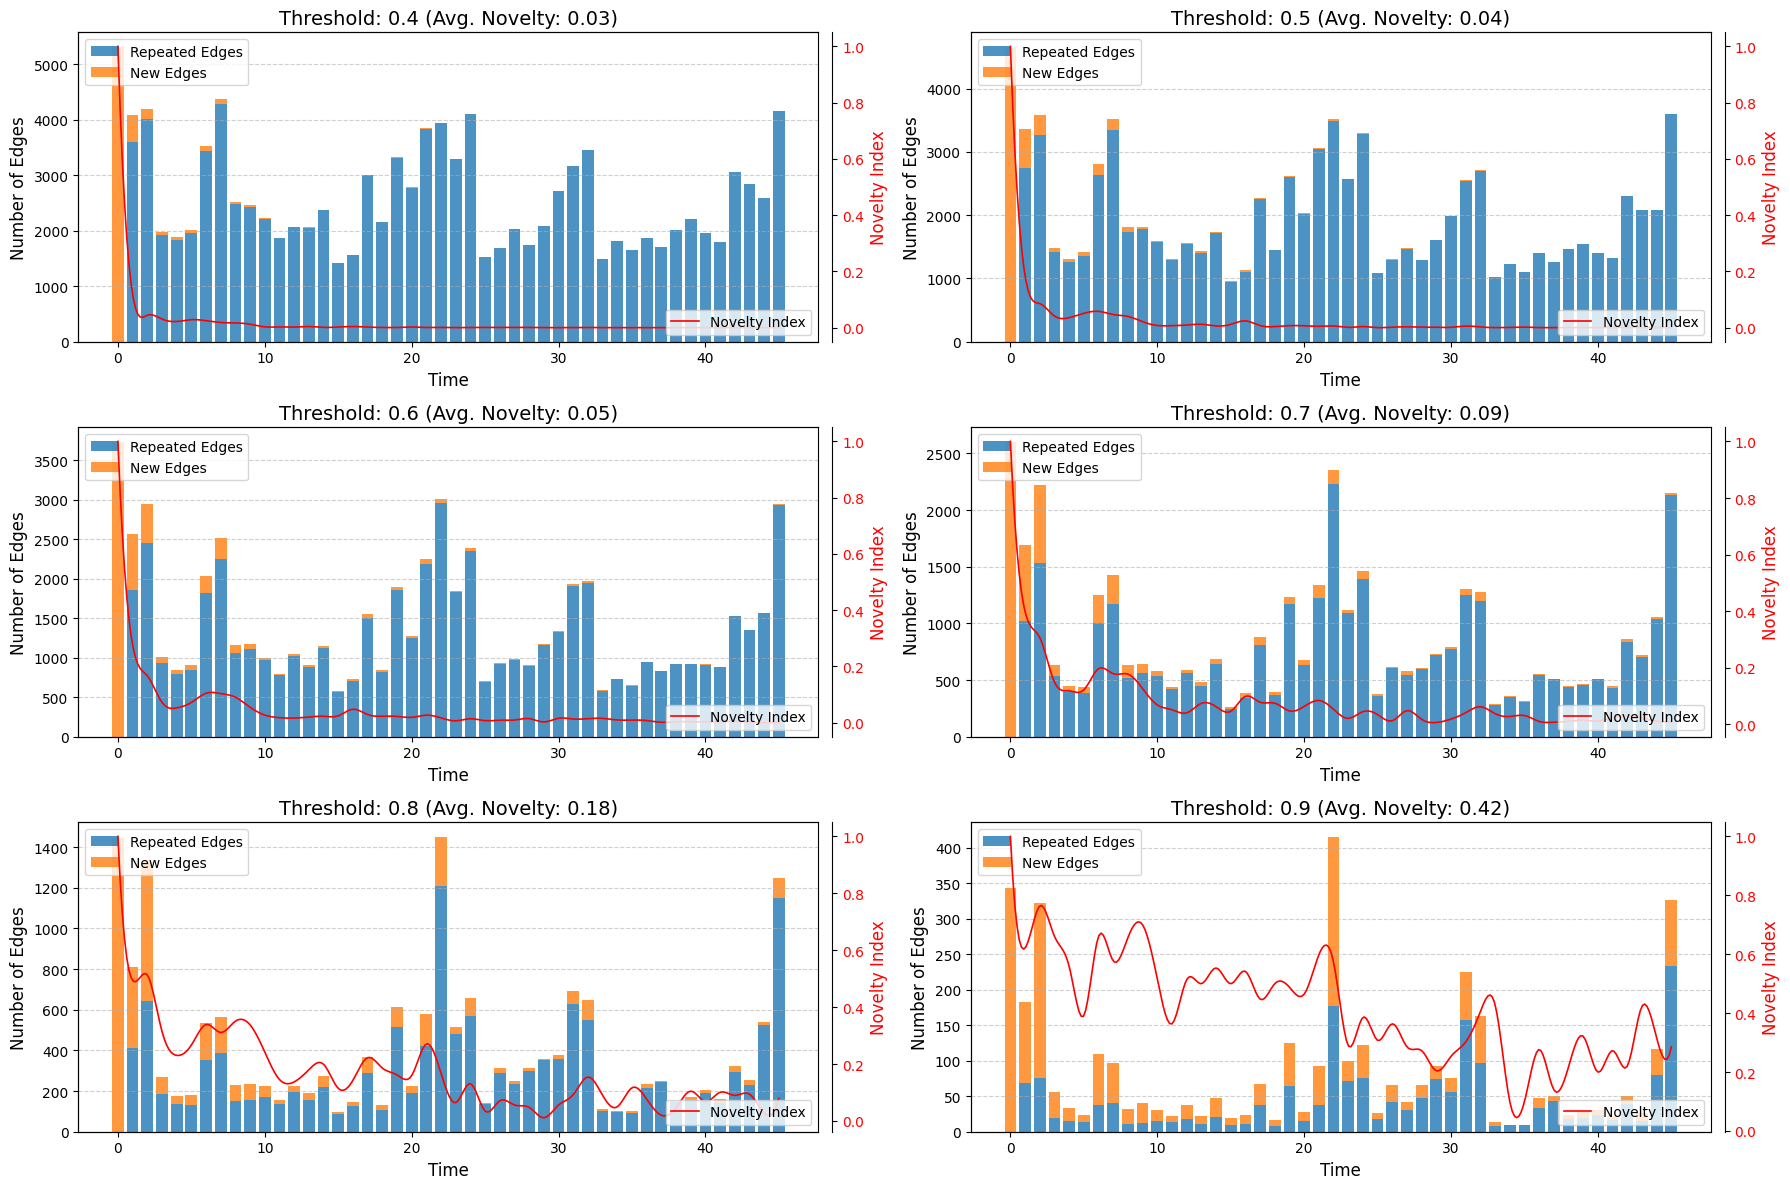

In [36]:
thresh_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)

## Rating_ToM

In [61]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO

def _read_second_rating_block(csv_path: str) -> np.ndarray:

    with open(csv_path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, ln in enumerate(lines):
        if "%%%%%%" in ln:
            start = i + 1
            break

    numeric_text = "".join(lines[start:])
    df = pd.read_csv(StringIO(numeric_text), header=None, names=["Second", "Rating"])
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    mat = df[["Second", "Rating"]].to_numpy(dtype=np.float32)  # (N, 2)
    return mat

def load_tp_all_subjects(
    root_dir: str,
    target_file_pattern: str = "S01-TP.csv",  
    strict_same_length: bool = True,         
    pad_value: float = np.nan,                
):
    root = Path(root_dir)
    paths = sorted(root.glob(f"*/{target_file_pattern}"))
    if not paths:
        raise FileNotFoundError(f"no {root}/*/{target_file_pattern}")

    mats = []
    subjects = []
    lengths = []
    for p in paths:
        mat = _read_second_rating_block(str(p))  # (N, 2)
        mats.append(mat)
        subjects.append(p.parent.name)          
        lengths.append(mat.shape[0])

    if strict_same_length:
        N = lengths[0]
        if any(L != N for L in lengths):
            details = ", ".join(f"{s}:{L}" for s, L in zip(subjects, lengths))
            raise ValueError("N is not same：\n" + details)
        arr = np.stack(mats, axis=0).astype(np.float32)  # (num_subjects, N, 2)
    else:
        maxN = max(lengths)
        arr = np.full((len(mats), maxN, 2), pad_value, dtype=np.float32)
        for i, mat in enumerate(mats):
            n = mat.shape[0]
            arr[i, :n, :] = mat
        N = maxN

    return arr, subjects  # arr.shape = (num_subjects, N, 2)

cube, subj_ids = load_tp_all_subjects("./Movie_ROI/Rating_ToM", target_file_pattern="*-PC.csv", strict_same_length=True)

print("cube shape:", cube.shape)     # (num_subjects, N, 2)
print("subjects:", subj_ids[:5])


cube shape: (34, 1396, 2)
subjects: ['S01', 'S02', 'S03', 'S04', 'S05']


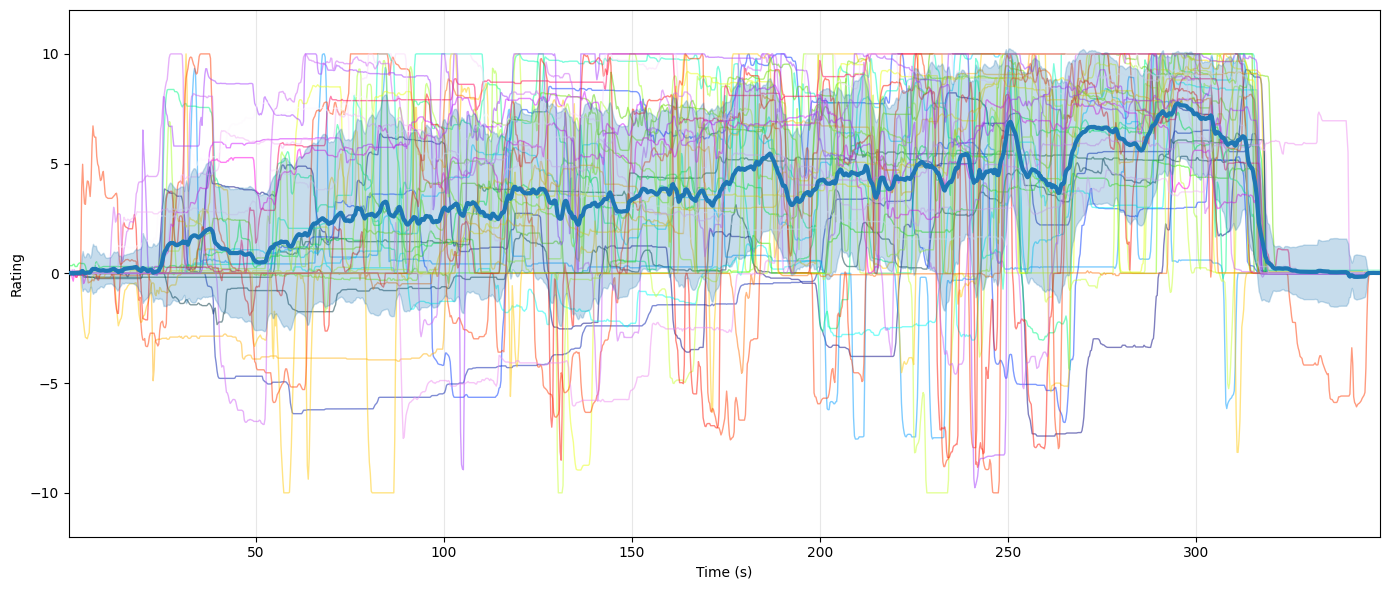

In [62]:
import numpy as np
import matplotlib.pyplot as plt

S, N, D = cube.shape
T_all = cube[:, :, 0].astype(float)
t_ref = T_all[0]
Y_all = cube[:, :, 1].astype(float)
mean_y = np.nanmean(Y_all, axis=0)
std_y  = np.nanstd(Y_all, axis=0, ddof=0)

colors = plt.cm.gist_ncar(np.linspace(0, 1, S))
fig, ax = plt.subplots(figsize=(14, 6))

for i in range(S):
    x = cube[i, :, 0]           # seconds
    y = cube[i, :, 1]           # rating
    ax.plot(x, y, color=colors[i], lw=1.0, alpha=0.5, label=f"S{i+1}")

(line_mean,) = ax.plot(t_ref, mean_y, lw=3.0, zorder=3, label="Mean rating")
ax.fill_between(t_ref, mean_y - std_y, mean_y + std_y,
                color=line_mean.get_color(), alpha=0.25, label="±1 SD", zorder=2)


max_s = float(np.nanmax(cube[:, :, 0]))
ticks = np.arange(0, (int(max_s // 50) + 1) * 50 + 1, 50)
ax.set_xticks(ticks)
ax.set_xlim(x.min(), max_s)

ax.set_ylim(-12, 12)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Rating")
ax.grid(True, axis="x", alpha=0.3)

# ax.legend(ncol=4, fontsize=8, frameon=False, loc="upper right")

fig.tight_layout()
fig.savefig("ratings_all_subjects_pc.png", dpi=300, bbox_inches="tight") 
plt.show()


# movie_pc

In [37]:
csv_path = "./Movie_ROI/movie_pc/sub-pixar003_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

root_dir = "./Movie_ROI/movie_pc"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 167)
roi_all shape: (82, 114, 167)
num_subjects: 82
first 3 subjects: ['pixar003', 'pixar005', 'pixar008']


# movie_dm

In [38]:
csv_path = "./Movie_ROI/movie_dm/sub-NDARAE012DGA_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

root_dir = "./Movie_ROI/movie_dm"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 739)
roi_all shape: (83, 114, 739)
num_subjects: 83
first 3 subjects: ['NDARAE012DGA', 'NDARAG115LZP', 'NDARCG808HDJ']
